# TESTES ESTATÍSTICOS

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from scipy.stats import shapiro, levene, bartlett, f_oneway, ttest_1samp, ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.diagnostic import lilliefors

def load_result(filename: str):
    with open(filename + '.json', 'r') as file:
        return json.load(file)    
    
resultado = load_result('resultado')
resultado['todos'] = resultado.pop('todos')
resultado['ids+cba'] = resultado.pop('2em2')
# LX-TimeAnalyzer
f1_baseline = 0.625 
acc_baseline = 0.669

## DIVISÃO DOS DADOS

10-folds: As sentenças dos dados de teste foram particionadas em 10 partes iguais, resultando na criação de 10 subconjuntos distintos, sendo que em cada subconjunto uma parte diferente foi removida. Não há nenhuma sentença em todos os subconjuntos.

## RESUMO RESULTADOS

In [9]:
rotulos = list(resultado.keys())
experimentos = []

for alg in resultado:
    list_f1 = resultado[alg]['f1_score']
    globals()["list_f1_" + alg] = list_f1  ##lista de F1 de cada conjunto de regras: list_f1_cba, list_f1_cn2, ...
    experimentos.append(list_f1)

print("{0:<10} {1:<10} {3:<10} {2}".format('ALGORITMO', 'MÉDIA', 'F1 DAS AMOSTRAS', 'VARIÂNCIA'))
for alg in resultado:
    list_f1 = resultado[alg]['f1_score']
    list_sup = np.array(resultado[alg]['support'])

    print("{0:<10} {2:<10.5f} {3:<10.6f} {1}".format(alg.upper(), list_f1, np.average(list_f1), np.var(list_f1, )))

print('\nSuportes:', list_sup)
print('MÉDIA SUPORTE:', np.mean(list_sup), '| MÉDIA DE CADA SUBSAMPLING:', format(np.mean(list_sup / 169), '.1%'), 'dos dados de teste')

ALGORITMO  MÉDIA      VARIÂNCIA  F1 DAS AMOSTRAS
CBA        0.60543    0.000449   [0.59437, 0.61536, 0.59865, 0.61175, 0.61216, 0.64804, 0.60086, 0.61312, 0.55826, 0.60171]
CN2        0.61323    0.000284   [0.59522, 0.62001, 0.61415, 0.61435, 0.61505, 0.62136, 0.60122, 0.65466, 0.59183, 0.60447]
IDS        0.60668    0.000301   [0.59345, 0.61859, 0.59855, 0.59723, 0.62482, 0.60793, 0.58749, 0.64095, 0.58241, 0.61538]
RIPPER     0.66125    0.000401   [0.64046, 0.67816, 0.66296, 0.65854, 0.66599, 0.67154, 0.64556, 0.69926, 0.62335, 0.66667]
MANUAIS    0.58058    0.000261   [0.5616, 0.59268, 0.59128, 0.58149, 0.57496, 0.56765, 0.57748, 0.61358, 0.55572, 0.58938]
TODOS      0.63298    0.000440   [0.61699, 0.64211, 0.62809, 0.63618, 0.64526, 0.65697, 0.6172, 0.6589, 0.58524, 0.64287]
IDS+CBA    0.63417    0.000417   [0.61883, 0.6386, 0.63684, 0.61821, 0.64746, 0.65943, 0.62644, 0.66106, 0.59009, 0.64471]

Suportes: [151 154 160 153 155 143 156 150 143 156]
MÉDIA SUPORTE: 152.1 | MÉDIA DE CA

## TESTAR NORMALIDADE

In [22]:
#Se p-value for maior que um nível de significância (0.05), 
#não há evidências suficientes para rejeitar a hipótese nula de que os dados seguem uma distribuição normal.  

#Teste de Lilliefors (Kolmogorov-Smirnov adaptado): 
#O teste de Lilliefors é uma variação do teste de Kolmogorov-Smirnov que é ajustado para estimar os parâmetros a partir dos dados da amostra. 
#É útil para testar a normalidade em amostras pequenas quando os parâmetros da distribuição não são conhecidos.

p_values = []
p_values_l = []
print('{0:<10} {1:<15} {2:<10} {3} {4}'.format('CONJUNTO', 'VARIÂNCIA', 'SHAPIRO', 'LILLIEFORS',  'NORMAL (se p>0.05)'))
for alg in resultado:
    list_f1 = resultado[alg]['f1_score']
    list_acc = resultado[alg]['accuracy']
    list_sup = np.array(resultado[alg]['support'])
    
    #Se o valor de p for menor que algum limite, por exemplo, 0,05, poderemos rejeitar a hipótese nula de que a amostra é proveniente de uma distribuição normal.
    statistic, p_value = shapiro(list_f1)
    statistic_l, p_value_l = lilliefors(list_f1)
    
    p_values.append(p_value)
    p_values_l.append(p_value_l)
    print("{0:<10} {1:<15.6f} {2:<10.6f} {3:<10.6f} {4}".format(alg.upper(), np.var(list_f1), p_value, p_value_l, 'Normal' if (p_value > 0.05) and (p_value_l > 0.05) else 'Não Normal'))
print('\nSHAPIRO:    p_value médio:', np.mean(p_values))
print('LILLIEFORS: p_value médio:', np.mean(p_values_l))

CONJUNTO   VARIÂNCIA       SHAPIRO    LILLIEFORS NORMAL (se p>0.05)
CBA        0.000449        0.184257   0.158922   Normal
CN2        0.000284        0.132083   0.180453   Normal
IDS        0.000301        0.826249   0.548605   Normal
RIPPER     0.000401        0.951571   0.761117   Normal
MANUAIS    0.000261        0.909333   0.837252   Normal
TODOS      0.000440        0.327810   0.657387   Normal
IDS+CBA    0.000417        0.597541   0.757626   Normal

SHAPIRO:    p_value médio: 0.5612633100577763
LILLIEFORS: p_value médio: 0.5573373139755657


## TESTAR HOMOGENEIDADE DAS VARIÂNCIAS

In [11]:
#O teste de Levene verifica a igualdade das variâncias entre dois ou mais grupos. 
#Ele é considerado menos sensível às violações da suposição de normalidade dos dados. 

#Se o valor-p for maior que o nível de significância (0,05), 
#não há evidências suficientes para rejeitar a hipótese nula de igualdade das variâncias.

# *experimentos = list_f1_cba, list_f1_cn2, list_f1_ids, ...
statistic, p_value = levene(*experimentos)
print('LEVENE:   p-value:', p_value, ' -> variâncias iguais' if p_value > 0.05 else 'variâncias diferentes')

statistic, p_value = bartlett(*experimentos)
print('BARTLETT: p-value:', p_value, ' -> variâncias iguais' if p_value > 0.05 else 'variâncias diferentes')

LEVENE:   p-value: 0.9905688315847655  -> variâncias iguais
BARTLETT: p-value: 0.9710829466604602  -> variâncias iguais


## TESTAR DIFERENÇAS ENTRE AS MÉDIAS

### ANOVA 
Verifica se há diferença entre as médias de algum experimento

In [12]:
#Um p_value menor que um nível de significância (0.05) indica que existe uma diferença 
#significativa entre pelo menos um par de médias dos experimentos.
anova = f_oneway(*experimentos)
print('p_value:', anova.pvalue, '->', 'há diferença entre as médias' if anova.pvalue < 0.05 else 'não há diferença')

p_value: 2.0750144877931308e-11 -> há diferença entre as médias


### ANOVA - EM TODOS OS PARES
Verifica quais experimentos possuem diferença significativa entre as médias do f1-score   
Sem controle do erro global do teste

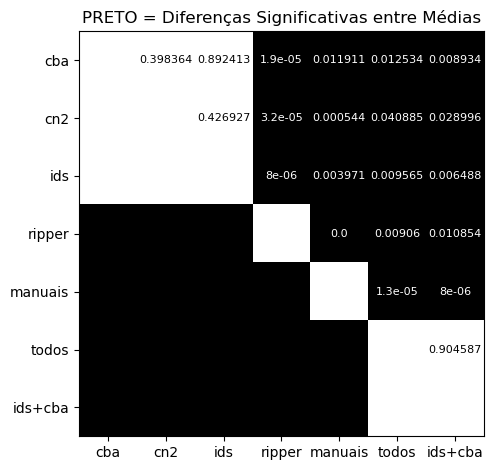

In [13]:
#Condições que devem ser atendidas: Normalidade e Homogeneidade de variância
#Aplicar ANOVA de dois em dois não oferece controle do erro global do teste. Elevando risco de erro tipo I (rejeitar erroneamente a hipótese nula quando ela é verdadeira).

#Se o valor-p for menor que um certo nível de significância (0,05), 
#podemos rejeitar a hipótese nula de que as médias das duas amostras são iguais.
num_experimentos = len(experimentos)
matrix_resultados = np.zeros((num_experimentos, num_experimentos), dtype=bool)
for i in range(num_experimentos):
    for j in range(num_experimentos):
        _, p_value = f_oneway(experimentos[i], experimentos[j])
        matrix_resultados[i, j] = p_value < 0.05

fig, ax = plt.subplots()
im = ax.imshow(matrix_resultados, cmap='binary')
for i in range(num_experimentos):
    for j in range(i+1, num_experimentos):
        cor = 'w' if matrix_resultados[i, j] else 'black'
        p_value = round(f_oneway(experimentos[i], experimentos[j])[1], 6)
        #print(rotulos[i], rotulos[j], f_oneway(experimentos[i], experimentos[j])[1])
        text = ax.text(j, i, p_value, ha='center', va='center', color=cor, fontsize=8)

plt.xticks(np.arange(num_experimentos), rotulos)
plt.yticks(np.arange(num_experimentos), rotulos)
plt.title('PRETO = Diferenças Significativas entre Médias')
plt.tight_layout()
plt.show()

### TESTE DE TUKEY DE COMPARAÇÃO MÚLTIPLA
Extensão do ANOVA, é usado para identificar quais grupos têm médias significativamente diferentes entre si.   
Com controle do erro global do teste



In [14]:
#Condições que devem ser atendidas: Normalidade e Homogeneidade de variância
#Evita o erro tipo I, ou seja, a probabilidade de rejeitar erroneamente a hipótese nula quando ela é verdadeira.
#Controla o erro global do teste em comparações múltiplas.
#Adequado para experimentos com três ou mais grupos. 

#meandiff: A diferença média entre as médias dos grupos comparados. 
#p-adj: O valor-p ajustado para cada comparação. Corrigido para comparações múltiplas, levando em consideração o número de comparações realizadas.
#lower/upper: O limite inferior/superior do intervalo de confiança para a diferença entre as médias dos grupos comparados.
#se reject for True, a diferença entre as médias é estatisticamente significativa; se for False, não há evidência suficiente para rejeitar a igualdade das médias.

dados = {}
for alg in resultado:
    dados[alg.upper()] = resultado[alg]['f1_score']
    
df = pd.DataFrame(dados)
df_pivot = pd.melt(df.reset_index(), id_vars=['index'], value_vars=df.columns, var_name='Experimento', value_name='Valor')

resultado_tukey = pairwise_tukeyhsd(df_pivot['Valor'], df_pivot['Experimento'])
print('Reject = True -> rejeitar a hipótese nula de que as médias das duas amostras são iguais.\n')
print(resultado_tukey)

#com p_value completo
#[f"{l[0]}|{l[1]}|{resultado_tukey.pvalues[i-1]}|{l[6]}" for i, l in enumerate(resultado_tukey._results_table.data) if i > 0]

Reject = True -> rejeitar a hipótese nula de que as médias das duas amostras são iguais.

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
    CBA     CN2   0.0078 0.9762 -0.0196  0.0352  False
    CBA     IDS   0.0013    1.0 -0.0262  0.0287  False
    CBA IDS+CBA   0.0287  0.034  0.0013  0.0562   True
    CBA MANUAIS  -0.0248 0.1005 -0.0523  0.0026  False
    CBA  RIPPER   0.0558    0.0  0.0284  0.0832   True
    CBA   TODOS   0.0276 0.0481  0.0001   0.055   True
    CN2     IDS  -0.0066 0.9903  -0.034  0.0209  False
    CN2 IDS+CBA   0.0209 0.2484 -0.0065  0.0484  False
    CN2 MANUAIS  -0.0327 0.0098 -0.0601 -0.0052   True
    CN2  RIPPER    0.048    0.0  0.0206  0.0754   True
    CN2   TODOS   0.0197 0.3136 -0.0077  0.0472  False
    IDS IDS+CBA   0.0275  0.049  0.0001  0.0549   True
    IDS MANUAIS  -0.0261 0.0722 -0.0535  0.0013  False
    IDS  RIPPER   0.0546    0.

### COMPARAÇÃO ANOVA x TUKEY
Se <span style="color:green;">True</span>, a diferença entre as médias é estatisticamente significativa

G1|G2|Rank_Tukey|pTUKEY|TUKEY|Rank_ANOVA|pANOVA|ANOVA
--|--|---------:|-----:|-----|---------:|-----:|-----
MANUAIS|RIPPER|1|0,000000000|<span style="color:green;">True</span>|1|0,000000023|<span style="color:green;">True</span>
CBA|RIPPER|2|0,000000989|<span style="color:green;">True</span>|5|0,000019122|<span style="color:green;">True</span>
IDS|RIPPER|3|0,000001705|<span style="color:green;">True</span>|2|0,000007859|<span style="color:green;">True</span>
IDS+CBA|MANUAIS|4|0,000002611|<span style="color:green;">True</span>|3|0,000007935|<span style="color:green;">True</span>
MANUAIS|TODOS|5|0,000004350|<span style="color:green;">True</span>|4|0,000012842|<span style="color:green;">True</span>
CN2|RIPPER|6|0,000027814|<span style="color:green;">True</span>|6|0,000031636|<span style="color:green;">True</span>
CN2|MANUAIS|7|0,009821699|<span style="color:green;">True</span>|7|0,000544307|<span style="color:green;">True</span>
IDS+CBA|CBA|8|0,033972367|<span style="color:green;">True</span>|10|0,008934112|<span style="color:green;">True</span>
RIPPER|TODOS|9|0,039069554|<span style="color:green;">True</span>|11|0,009060118|<span style="color:green;">True</span>
CBA|TODOS|10|0,048097776|<span style="color:green;">True</span>|15|0,012534321|<span style="color:green;">True</span>
IDS+CBA|IDS|11|0,049016525|<span style="color:green;">True</span>|9|0,006488261|<span style="color:green;">True</span>
IDS+CBA|RIPPER|122|0,054995611|False|13|0,010854490|<span style="color:green;">True</span>
IDS|TODOS|13|0,068318235|False|12|0,009565116|<span style="color:green;">True</span>
IDS|MANUAIS|14|0,072200768|False|8|0,003971396|<span style="color:green;">True</span>
CBA|MANUAIS|15|0,100469588|False|14|0,011910969|<span style="color:green;">True</span>
IDS+CBA|CN2|16|0,248434700|False|16|0,028995937|<span style="color:green;">True</span>
CN2|TODOS|17|0,313572021|False|17|0,040885199|<span style="color:green;">True</span>
CBA|CN2|18|0,976151333|False|18|0,398364128|False
CN2|IDS|19|0,990326343|False|19|0,426926871|False
CBA|IDS|20|0,999999332|False|20|0,892412991|False
IDS+CBA|TODOS|21|0,999999516|False|21|0,904587040|False


## GRÁFICO DE DENSIDADE

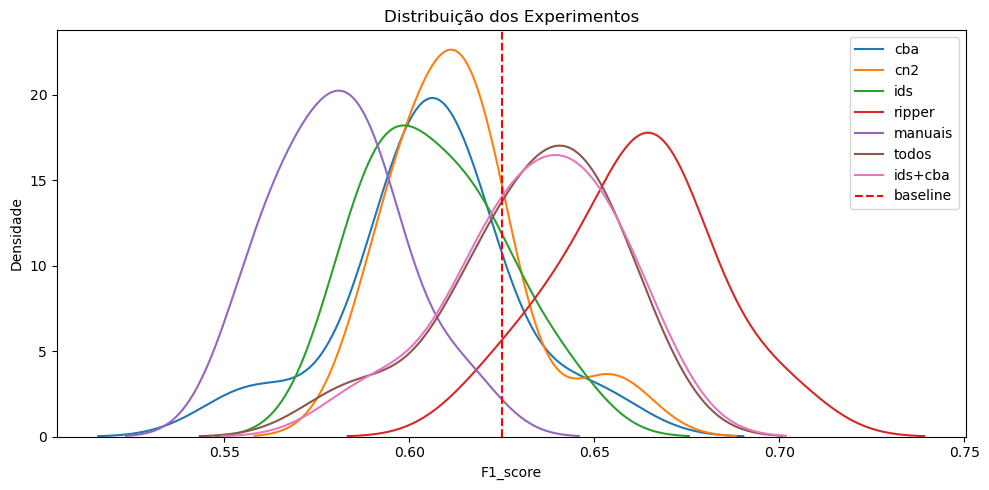

In [16]:
fig, ax = plt.subplots(figsize=(10,5))

for i, experimento in enumerate(experimentos):
    sns.kdeplot(experimento, ax=ax, label=rotulos[i])

ax.axvline(x=f1_baseline, color='r', linestyle='--', label='baseline')

plt.xlabel('F1_score')
plt.ylabel('Densidade')
plt.title('Distribuição dos Experimentos')
plt.legend()
plt.tight_layout()
plt.show()

## COMPARANDO COM BASELINE

Teste t de Student de uma amostra

In [45]:
#Se o p_value for menor que o nível de significância (0,05), 
#pode-se concluir que a média do experimento é estatisticamente diferente do baseline.
#p-value = a probabilidade de obter uma diferença tão grande ou maior entre a média dos experimentos e o baseline, assumindo que as médias são iguais.

print("{0:<10} {1:>6} {2:>12} {3:<18} {4:>8} {5:>12}".format('ALGORITMO', 'T-STAT', 'P_VALUE', 'COMP BASELINE', 'MÉDIA F1', 'F1 BASELINE'))
for alg in resultado:
    list_f1 = resultado[alg]['f1_score']
    t_statistic, p_value = ttest_1samp(list_f1, f1_baseline)
    print("{0:<10} {1:>6.2f} {2:>12.8f} {3:<18} {4:>8.4f} {5:>12}".format(alg.upper(), t_statistic, p_value, 'diferente ' + ('melhor' if t_statistic > 0 else 'pior') if p_value < 0.05 else 'igual', np.average(list_f1), f1_baseline))

ALGORITMO  T-STAT      P_VALUE COMP BASELINE      MÉDIA F1  F1 BASELINE
CBA         -2.77   0.02168160 diferente pior       0.6054        0.625
CN2         -2.10   0.06554947 igual                0.6132        0.625
IDS         -3.17   0.01140852 diferente pior       0.6067        0.625
RIPPER       5.43   0.00041736 diferente melhor     0.6612        0.625
MANUAIS     -8.24   0.00001745 diferente pior       0.5806        0.625
TODOS        1.14   0.28300835 igual                0.6330        0.625
IDS+CBA      1.35   0.21091993 igual                0.6342        0.625


Gráfico de Comparação Simultânea de Médias pelo Teste de Tukey


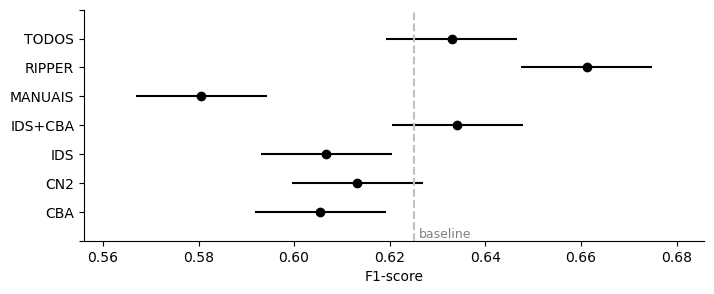

In [18]:
# CONFIRMANDO COM INTERVALO DE CONFIANÇA DE TUKEY
resultado_tukey.plot_simultaneous(figsize=(8,3), xlabel='F1-score')
plt.axvline(x=f1_baseline, color='silver', linestyle='--', label='baseline')
plt.text(f1_baseline + 0.001, -0.9, 'baseline', color='gray', fontsize=9)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

print('Gráfico de Comparação Simultânea de Médias pelo Teste de Tukey')
plt.title("")
plt.show()
